In [6]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd


In [7]:
import osmnx as ox
from shapely.geometry import Point

#The three microhub addresses
centrum_address = "Wal 6, Eindhoven, Netherlands"
blix_address   = "Ouverture 51, Eindhoven, Netherlands"
meer_address   = "Meerwater 20, Eindhoven, Netherlands"

# How to get lat long tuples
centrum_latlon = ox.geocode(centrum_address)
blix_latlon   = ox.geocode(blix_address)
meer_latlon   = ox.geocode(meer_address)

# Convert to Shapely Point objects
point_centrum = Point(centrum_latlon[1], centrum_latlon[0])
point_blix   = Point(blix_latlon[1], blix_latlon[0])
point_meer   = Point(meer_latlon[1], meer_latlon[0])

# Check the points
print("Centrum point:", point_centrum)
print("Blixembosch point:", point_blix)
print("Meerhoven point:", point_meer)



Centrum point: POINT (5.4784873 51.4360644)
Blixembosch point: POINT (5.4733707 51.4880232)
Meerhoven point: POINT (5.4087512 51.4422011)


In [8]:
import osmnx as ox
from shapely.ops import unary_union

# Project each point to its appropriate UTM (meter‐based) CRS
point_centrum_proj, crs_utm = ox.projection.project_geometry(point_centrum)
point_blix_proj, _      = ox.projection.project_geometry(point_blix, to_crs=crs_utm)
point_meer_proj, _      = ox.projection.project_geometry(point_meer, to_crs=crs_utm)

# Buffer each projected point by 5kms
buffer_distance = 4000
poly_centrum_proj = point_centrum_proj.buffer(buffer_distance)
poly_blix_proj   = point_blix_proj.buffer(buffer_distance)
poly_meer_proj   = point_meer_proj.buffer(buffer_distance)

#Union them into one projected polygon
combined_proj_union = unary_union([poly_centrum_proj, poly_blix_proj, poly_meer_proj])

#Reproject the unioned polygon back
combined_area = ox.projection.project_geometry(combined_proj_union, crs=crs_utm, to_latlong=True)[0]

# Check that combined_area is a valid polygon in lon/lat
print(type(combined_area), combined_area.geom_type)


<class 'shapely.geometry.polygon.Polygon'> Polygon


In [9]:
# Download bike network using the combined lat/lon polygon
G_bike = ox.graph_from_polygon(combined_area, network_type="bike", simplify=True)

# Download walk network in the same area
G_walk = ox.graph_from_polygon(combined_area, network_type="walk", simplify=True)


In [10]:
# Save to GraphML in data/raw/
ox.save_graphml(G_bike, filepath="../data/raw/bike_network.graphml")
ox.save_graphml(G_walk, filepath="../data/raw/walk_network.graphml")


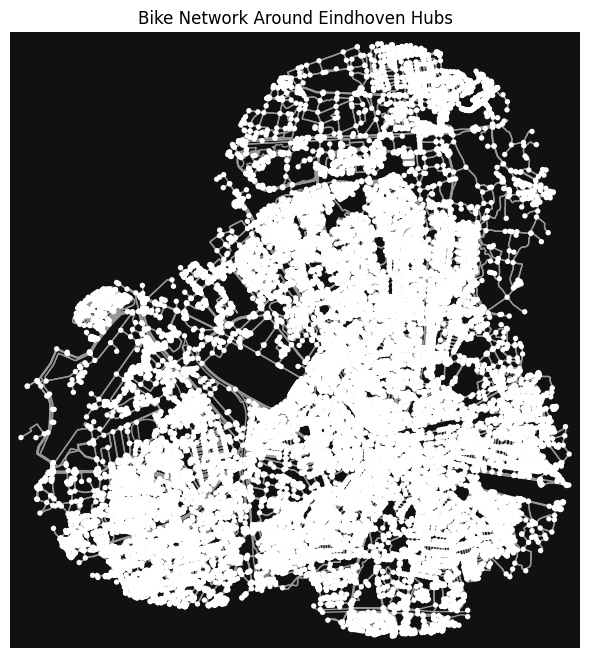

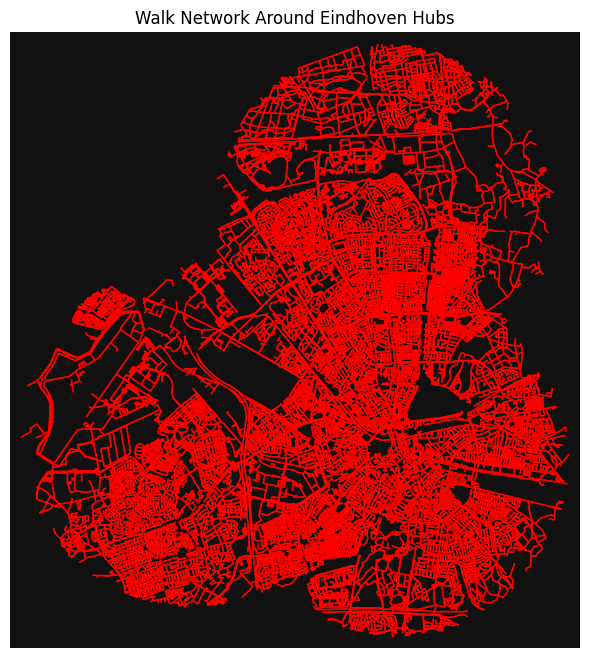

In [11]:
# plot bike network
fig1, ax1 = ox.plot_graph(G_bike, show=False, close=False)
ax1.set_title("Bike Network Around Eindhoven Hubs")

# plot walk network
fig2, ax2 = ox.plot_graph(G_walk, show=False, close=False, node_size=0, edge_color="red")
ax2.set_title("Walk Network Around Eindhoven Hubs")

del G_bike
del G_walk